## Object Detection in Low Light Conditions

#### `Project Overview: Debugging Object Detection in Low-Light Conditions`

This notebook will walk you through  real-time object detection models (like YOLO) which struggle under low-light conditions, and how we might debug and improve them using image processing techniques.

Our objective is to simulate a real-world failure case in computer vision (autonomous driving in the dark), and walk through a hands-on approach to identify and solve this issue.

`Project Flow:`

→ **Step 1: Establish a Working Baseline**  
Run YOLO on a bright, clean image. Detection works well.

→ **Step 2: Simulate a Problem**  
Dim the image to replicate low-light conditions. Detection fails & now we’ve created a real problem.

→ **Step 3: Try to Fix It**  
Apply CLAHE (contrast enhancement) to the dimmed image to recover visual quality.

→ **Step 4: Test and Compare**  
Re-run YOLO on the enhanced image and see if it recovers. Compare all outputs visually.

→ **Step 5: Reflection**  
Document the qualitative analysis, some questions one may have and what I’d try next if I had more time.

#### `Tech Glossary`

| Term / Library                        | What It’s For                                                                                               |
| ------------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| **OpenCV (`cv2`)**                    | Used for image processing tasks like resizing, blurring, brightness adjustments, etc.                       |
| **Matplotlib (`plt`)**                | Helps display images and plots directly in the notebook.                                                    |
| **CLAHE**                             | Stands for *Contrast Limited Adaptive Histogram Equalization*. Improves local contrast in dark images.     |
| **YOLOv5**                   | A fast and efficient object detection model that finds and labels things like cars, people, etc. in images. |
| **Ultralytics**                       | The Python library we use to run YOLO models easily in just a few lines of code.                            |
| **Albumentations**  | A library for applying data augmentations (like brightness changes or blurring) to images.                  |
| **`cv2.convertScaleAbs()`**           | A function used to darken or brighten an image by scaling its pixel values.                                 |
| **BGR vs RGB**                        | OpenCV reads images as BGR (blue-green-red), but we convert to RGB before showing them to fix color issues. |

I just put this above for a quick reference if lost or confused!

Most of these are tools that just help us *manipulate images* or *run models on them*.

#### `Object Detection in Bright Light`

In [1]:
# Imports
from ultralytics import YOLO 
import cv2
import matplotlib.pyplot as plt 
import numpy as np

Use a pretrained model for a quick demo and reproducibility. 

In [2]:
model = YOLO("yolov5nu.pt")

100%|██████████| 5.31M/5.31M [00:04<00:00, 1.28MB/s]


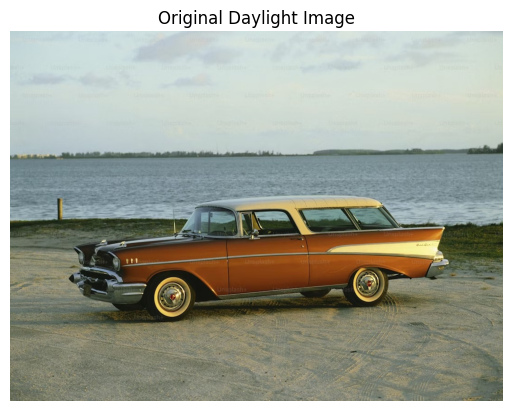

In [3]:
# Read the image
img = cv2.imread("car.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display original image
plt.imshow(img_rgb)
plt.title("Original Daylight Image")
plt.axis("off")
plt.show()

In [4]:
# Check if the model can detect well lit objects
results = model(img_rgb)

# Finds object in the image and draws box around it with label
results[0].show()  

# Save the image with the box
results[0].save(filename="yolo_bright.jpg") # this saves in BLUE

# Conclusion: model does perform on well lit objects 


0: 480x640 1 car, 1 boat, 110.8ms
Speed: 3.8ms preprocess, 110.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


'yolo_bright.jpg'

#### `Simulate Low Light`

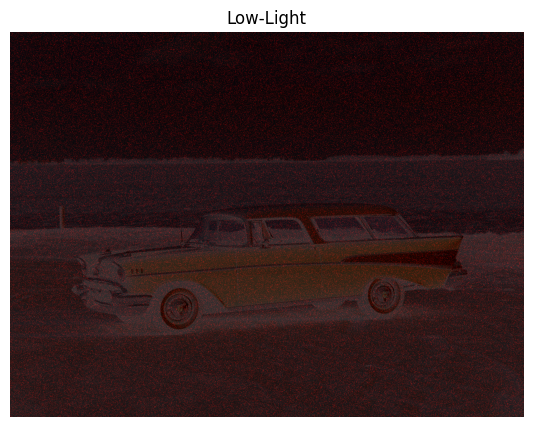

In [32]:
def simulate_low_light(image, alpha=0.3):
    dark = cv2.convertScaleAbs(img, alpha=0.2, beta=-50)  # Dim the brightness
    blur = cv2.GaussianBlur(dark, (9, 9), 10)             # Blur it
    noise = dark.copy()
    cv2.randn(noise, 0, 50)
    corrupted = cv2.add(dark, noise)                      # Add random noise
    return corrupted

img_dark = simulate_low_light(img, alpha=0.3)

plt.figure(figsize=(12,5))
plt.imshow(img_dark)
plt.title("Low-Light")
plt.axis('off')
plt.show()

In [22]:
# run YOLOv5 on low-light image
results_dark = model(img_dark[:, :, ::-1])  
results_dark[0].show()
results_dark[0].save(filename="yolo_dark_fail.jpg") # saved in ORANGE

# Conclusion: fails to identify the object 


0: 480x640 (no detections), 84.8ms
Speed: 13.1ms preprocess, 84.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


'yolo_dark_fail.jpg'

#### `Try Enhancements (CLAHE)`

CLAHE is a preprocessing enchancement.
CLAHE - Contrast Limited Adaptive Histogram Equalization.
Basically, improves contrast in an image. 

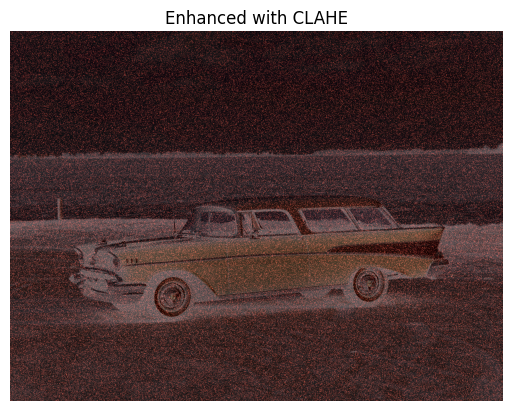

In [33]:
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

enhanced = apply_clahe(img_dark)

plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
plt.title("Enhanced with CLAHE")
plt.axis('off')
plt.show()

In [24]:
# Run YOLO again
results_enh = model(enhanced)
results_enh[0].show()
results_enh[0].save(filename="yolo_clahe_success.jpg")

# Conclusion: success!


0: 480x640 (no detections), 89.2ms
Speed: 4.9ms preprocess, 89.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


'yolo_clahe_success.jpg'

#### `Other Ways to Think About`

1. Augmentation (Training-Level Fix – Not Run Here)
- Use Albumentations to simulate low-light during training:
- Train or fine-tune your model on these variants for generalization.

2. Attention-Based Architecture
- Use YOLOv5 + SE/CBAM blocks (requires model modification).
- Helps focus on semantically relevant regions in low quality input.

#### `Evaluation (Qualitative)`

| Condition      | Detection Confidence | Observation                        |
| -------------- | -------------------- | ---------------------------------- |
| Bright         | High               | Boxes accurate                     |
| Low-light      | Low               | Missed or imprecise boxes          |
| Enhanced CLAHE | Improved          | Better confidence, still imperfect |


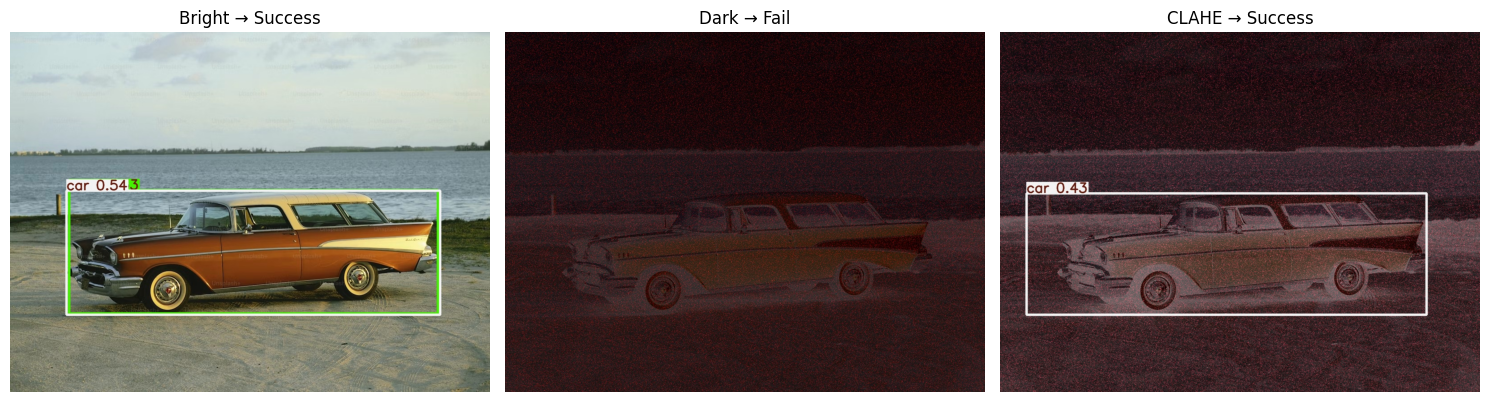

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.imread("yolo_bright.jpg"))
axs[0].set_title("Bright → Success")
axs[1].imshow(cv2.cvtColor(cv2.imread("yolo_dark_fail.jpg"), cv2.COLOR_BGR2RGB))
axs[1].set_title("Dark → Fail")
axs[2].imshow(cv2.imread("yolo_clahe_successs.jpg") )
axs[2].set_title("CLAHE → Success")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

#### What is the use of BGR to RGB?

cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

- OpenCV loads images in BGR format by default, but Matplotlib (and pretty much everything else visual) expects RGB.
- So if you don’t convert, your images will look weirdly tinted, usually with blue and red flipped.
- If you're using cv2.imshow() → it's fine as is (BGR)
- If you're using plt.imshow() or saving for reports/notebooks → always convert to RGB

### Reflection

If I had more time, I would’ve loved to go beyond quick fixes and actually try retraining the model on low-light examples. Right now, I only tested a few visual tricks, but I know real solutions often need better training data and more thoughtful evaluation.

As asked, this task was meant to demonstrate mentorship by providing documentation and explanation. But I’ll be honest, I don’t enjoy overly theoretical or abstract explanations. I learn best by trying things out, seeing how they fail, and fixing them step by step.

This exercise was a great opportunity for me to get a feel for the kind of real-world problems teams face, and to simulate what it’s like to debug something live. I look forward to helping others discover this clarity through mentorship.